In [100]:
import math
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt

from ta.utils import dropna
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.trend import MACD

# Hypothesis

From testing we found that simply using indicators was not enough to find tops and bottom and even mean reversion often did not work due to irrational investors and market risk

Hence, instead of longing at a potential lows, we wanted to test the returns of longing only in the middle of a new uptrend. 

Our strategy is as such:

Long when
1. Adj Close is between  50 day SMA value & (50 day SMA value + 3x ATR) 
        i.  A stronger signal is when Diff between (SMA & Adj Close) is large
2.  AND (MACD line(Fast)– Signal(Slow)) is also positive and large
        i. A stronger signal is when Diff between (MACD line(Fast)– Signal(Slow)) is large

Short when
1. Adj Close is between (50 day SMA value - 0.5x ATR) &  50 day SMA value 
        i.  A stronger signal is when Diff between (SMA & Adj Close) is large
2.  AND (MACD line(Fast)– Signal(Slow))  is also negative and large 
        i. A stronger signal is when Diff between (MACD line(Fast)– Signal(Slow)) is large


In [3]:
def get_signal_per_day(adj_close_val, sma_val,macd_fast_val, macd_slow_val,close_n_sma_distance_short_multiple, close_n_sma_distance_long_multiple,atr_val):
    """
    Function to visualise how signals are calculated for each day
    """
    
    signal_short = -1.0 if (adj_close_val>(sma_val-close_n_sma_distance_short_multiple*atr_val)) & (adj_close_val<sma_val) else 0
    signal_long_n_short = 1.0 if (adj_close_val<(sma_val+close_n_sma_distance_long_multiple*atr_val)) & (adj_close_val>sma_val) else signal_short
    singal_macd = 1.0 if (macd_fast_val>macd_slow_val) else -1.0
    final_signal = (signal_long_n_short+singal_macd)/2.0
    final_signal_clean = final_signal if (final_signal in [1.0,-1,0]) else 0
    signal_strength = ((abs(adj_close_val- sma_val)/adj_close_val + abs(macd_fast_val-macd_slow_val))) * final_signal_clean
    return final_signal_clean,signal_strength
    

In [4]:
get_signal_per_day(adj_close_val= 275.75,sma_val= 267,
                   macd_fast_val= 0.029,macd_slow_val= -1.59,
                   close_n_sma_distance_short_multiple= 0.5,
                   close_n_sma_distance_long_multiple= 3,
                   atr_val = 8.22)

(1.0, 1.6507316409791477)

### Importing Data

In [5]:
#NSElist . Dont run
india_stock_list  = ["BRITANNIA.NS", "ULTRACEMCO.NS","KOTAKBANK.NS", "HEROMOTOCO.NS" , "BAJAJ-AUTO.NS", "GRASIM.NS","ONGC.NS", "TITAN.NS" , "SHREECEM.NS" ,\
        "NESTLEIND.NS", "GAIL.NS", "CIPLA.NS", "BHARTIARTL.NS" ,"NTPC.NS", "TATASTEEL.NS", "COALINDIA.NS", "BAJFINANCE.NS", "ICICIBANK.NS",\
       "BAJAJFINSV.NS", "WIPRO.NS", "HINDALCO.NS" , "HDFCLIFE.NS", "MARUTI.NS", "RELIANCE.NS", "TCS.NS", "LT.NS", "INDUSINDBK.NS", "ITC.NS" , "TECHM.NS"]

In [6]:
#SGX Stock list. Dont run
sg_stock_list  = ["C52.SI", "T39.SI", "S68.SI", "G13.SI", "V03.SI" , "U11.SI", "C07.SI" , "D05.SI", "Z74.SI",\
        "D01.SI", "O39.SI", "S63.SI", "A17U.SI" , "BN4.SI","BS6.SI", "M44U.SI", "C31.SI", "H78.SI", \
        "Y92.SI", "C38U.SI", "U14.SI", "N2IU.SI" , "F34.SI" , "C09.SI" , "J36.SI", "S58.SI" , "C6L.SI", "J37.SI", "U96.SI" ,"1810.HK"]

In [85]:
def entry_price_plot(bt_data,plt,stock_symbol,buy_on = "Open"):
    """
    Function to plot the entry points and exits for each stock
    """
    plt.grid(True, alpha = .3)
    stock_price_df = bt_data[buy_on+"_" + stock_symbol]
    
    # Plotting the Closing prices and SMA for the chosen stock
    plt.plot(stock_price_df, label = f'Daily {buy_on} of {stock_symbol}')
    plt.plot(bt_data['SMA'+"_" + stock_symbol], label = 'SMA')
    
    # Entry Points
    open_long = (bt_data.Open_Entry == "Open Long") & (bt_data.Chosen == "Strength of Signal_"+stock_symbol)
    open_short = (bt_data.Open_Entry == "Open Short") & (bt_data.Chosen == "Strength of Signal_"+stock_symbol)
    
    # Exit points
    close_short_tp = (bt_data.Close_Entry == "Close Short at TP") & (bt_data["Invested in"] == stock_symbol)
    close_long_tp = (bt_data.Close_Entry == "Close Long at TP") & (bt_data["Invested in"] == stock_symbol)
    close_short_sl = (bt_data.Close_Entry == "Close Short at SL") & (bt_data["Invested in"] == stock_symbol)
    close_long_sl = (bt_data.Close_Entry == "Close Long at SL") & (bt_data["Invested in"] == stock_symbol)
    
    plt.plot(bt_data.loc[open_long].index, stock_price_df[open_long], '^',
             color = 'g', markersize = 12,alpha=0.6, label="Open Long")
    
    plt.plot(bt_data.loc[open_short].index, stock_price_df[open_short], 'v',
             color = 'r', markersize = 12,alpha=0.6, label="Open Short")
    
    plt.plot(bt_data.loc[close_long_tp].index, stock_price_df[close_long_tp], '*',
             color = 'g', markersize = 12,alpha=0.8, label="TP Long")
    
    plt.plot(bt_data.loc[close_short_tp].index, stock_price_df[close_short_tp], '*',
             color = 'r', markersize = 12,alpha=0.8, label="TP Short")
    
    plt.plot(bt_data.loc[close_long_sl].index, stock_price_df[close_long_sl], 'x',
             color = 'g', markersize = 12,alpha=0.8, label="SL Long", mew=4)
    
    plt.plot(bt_data.loc[close_short_sl].index, stock_price_df[close_short_sl], 'x',
             color = 'r', markersize = 12,alpha=0.8, label="SL Short", mew=4)
    
    plt.legend(loc=(1.04, 0));

In [86]:
def returns_plot_log(bt_data,plt,stock_symbol):
    """
    Function to plot the log returns of stock and strategy 
    """
    
    plt.plot(bt_data['Stock_Returns'+"_" + stock_symbol].cumsum(), label=f'Buy/Hold (Log Returns) of {stock_symbol}')
    plt.plot(bt_data['Strategy_Returns'].cumsum(), label=f'Strategy (Log Returns)')
    plt.legend(loc=(1.04, 0))
    plt.grid(True, alpha=.3)

In [87]:
def returns_plot_normal(bt_data,plt,stock_symbol):
    """
    Function to plot the normal returns of stock and strategy 
    """
    
    plt.plot(bt_data['Stock_Returns'+"_" + stock_symbol].cumsum().apply(np.exp), label=f'Buy/Hold (Normal Returns) of {stock_symbol}')
    plt.plot(bt_data['Strategy_Returns'].cumsum().apply(np.exp), label=f'Strategy (Normal Returns)')
    plt.legend(loc=(1.04, 0))
    plt.grid(True, alpha=.3)

In [88]:
def drawdown(bt_data,plt, col):
    """
    Function to plot the drawdown of column of returns 
    """
    
    bt_data["Gross_Cum_Returns"] = bt_data[col].cumsum().apply(np.exp) 
    bt_data["Cum_Max"] = bt_data["Gross_Cum_Returns"].cummax()

    plt.plot(bt_data["Gross_Cum_Returns"],label=f'Gross Cum Returns of {col}')
    plt.plot(bt_data["Cum_Max"],label=f'Cum Max of {col}')
    plt.legend(loc=(1.04, 0))
    
    drawdown = bt_data["Cum_Max"] - bt_data["Gross_Cum_Returns"] # it gives the difference between orange and blue

    bt_data["drawdown"] = drawdown

    # The maximum difference is refered as "Drawdown"
    print(f"Max Drawdown for {col} is {bt_data.drawdown.max()}")
    ## Try to keep to less than 15%

    zero_periods = drawdown[drawdown == 0]
    
    # Taking the difference from the previous period
    delta_values = zero_periods.index[1:] - zero_periods.index[:-1]

    print(f'Max days for drawdown for {col} is {delta_values.max()}')


In [89]:
def get_signals(stock_symbol, start, end,primary_trend_window = 200,buy_on="Close"):
    """
    Vectorised Function to get the signals for each day 
    """
    
    stock_data = pdr.get_data_yahoo(stock_symbol, start, end)
    SMA = SMAIndicator(close = stock_data['Adj Close'], window = primary_trend_window)
    ATR = AverageTrueRange(high = stock_data['High'],
                       low = stock_data['Low'],
                       close = stock_data['Adj Close'])
    
    MACD_ = MACD(close = stock_data['Adj Close'])  

    stock_data['SMA'] = SMA.sma_indicator()
    stock_data['ATR'] = ATR.average_true_range()
    stock_data['MACD Fast'] = MACD_.macd()
    stock_data['MACD Slow'] = MACD_.macd_signal()

    stock_data['Stop Loss'] = stock_data[buy_on] - long_sl_ATR_multiple*stock_data['ATR'] # 2
    stock_data['Take Profit'] = stock_data[buy_on] +risk_reward_long*(stock_data[buy_on] - stock_data['Stop Loss']) # 1
    
    stock_data['Stop Loss Short'] = stock_data[buy_on] + short_sl_ATR_multiple*stock_data['ATR'] # 1
    stock_data['Take Profit Short'] = stock_data[buy_on] -risk_reward_short*(stock_data['Stop Loss Short'] - stock_data[buy_on]) # 0.5

    bt_data = stock_data.copy()
    bt_data.dropna(inplace = True)

    # # Signal Logic
    bt_data['signal_1'] = np.where( 
                        (bt_data['Adj Close'] > (bt_data['SMA'] - close_n_sma_distance_short_multiple*bt_data['ATR']) ) & (bt_data['Adj Close'] < bt_data['SMA']),
                        -1.0,   0) # When it is between the close and abit below it, we short, 0,5
    
    bt_data['signal_1'] = np.where( 
                        (bt_data['Adj Close'] < (bt_data['SMA'] + close_n_sma_distance_long_multiple*bt_data['ATR']) ) & (bt_data['Adj Close'] > bt_data['SMA']) ,
                        1.0,  bt_data['signal_1']) # When it is between the close and abit above it, we long, 2
    
    bt_data['signal_2'] = np.where(bt_data['MACD Fast'] >  bt_data['MACD Slow'],1.0,-1.0)
    bt_data['Signal'] = ( bt_data['signal_1'] + bt_data['signal_2'] )/2.0
    bt_data['Signal Clean'] = bt_data['Signal'].map(lambda x : 0 if x not in [-1.0,1.0] else x)
    bt_data['Strength of Signal'] = ((abs(bt_data['Adj Close'] - bt_data['SMA'])/bt_data['Adj Close'] + abs(bt_data['MACD Fast'] -  bt_data['MACD Slow']))) * bt_data['Signal Clean']
    bt_data['Stock_Returns'] = np.log(bt_data[buy_on]/bt_data[buy_on].shift(1))
    return bt_data

In [90]:
def get_signal_for_mutiple_stocks(MAANG_list,start, end,primary_trend_window ,buy_on):
    """
    Function that combines data and signals for multiple stocks 
    """
    
    MAANG_list_abbr_list = []
    
    # Intialise df with first stock in list 
    signals_df = get_signals(MAANG_list[0], start, end,primary_trend_window,buy_on).add_suffix('_'+MAANG_list[0]) 
    MAANG_list_abbr_list.append("Strength of Signal_" +MAANG_list[0])
    for stock in MAANG_list[1:]:
        stock_df = get_signals(stock, start, end,primary_trend_window = primary_trend_window,buy_on = buy_on)
        signals_df= signals_df.merge(stock_df.add_suffix('_'+stock), how='right', left_index=True, right_index=True )
        MAANG_list_abbr_list.append("Strength of Signal_" +stock)

    signals_df['Chosen'] = signals_df[MAANG_list_abbr_list].abs().idxmax(axis=1)
    signals_df['Chosen'] = np.where (signals_df[MAANG_list_abbr_list].abs().max(axis = 1) == 0.0, 0, signals_df['Chosen'])
    temp_data = signals_df[MAANG_list_abbr_list].copy()

    # If there are many signals in one day, replace them with the stock with the strongest signal
    for i in range(len(temp_data)):
        if (temp_data[i:i+1].max(axis = 1)[0] != 0.0):
            stock_chosen = temp_data[i:i+1].abs().idxmax(axis=1)[0].split("_")[-1]
            signals_df.loc[signals_df.index[i],MAANG_list_abbr_list] = [0.0] * len(MAANG_list)
            signals_df.loc[signals_df.index[i],"Strength of Signal_"+stock_chosen] = signals_df.loc[signals_df.index[i],"Signal Clean_"+stock_chosen]

    return signals_df, temp_data

In [91]:
def get_positions(bt_data,buy_on, verbose = True ):
    """
    Function to set the entry points for the day.
    Once, entered position will stay in that stock untill it hits TP or SL
    After closing the position, based on the next signal a new position is opened.
    """
    
    latest_action,chosen_stock_for_entry = 0,""
    curr_stop, curr_TP,buy_price,short_price = 0,0,0,0
    bt_data[ "Open_Entry"] = 0.0
    bt_data[ "Close_Entry"] = ""
    bt_data[ "Stock_Returns_"] = 0.0
    bt_data[ buy_on+"_"] = 0.0
    
    # Loop through each day
    for i in range(len(bt_data)):
        curr_date = bt_data.index[i]
        
        # If we have no prev position and a new signal is asking to take a position
        if (bt_data['Chosen'].iloc[i] != 0.0) & (latest_action == 0):

            chosen_stock_for_entry = bt_data['Chosen'].iloc[i].split('_')[-1]
            
            # Enter Long on chosen stock
            if (bt_data["Signal Clean_"+chosen_stock_for_entry].iloc[i]  == 1.0):
                curr_stop, curr_TP = bt_data.iloc[i]["Stop Loss_"+chosen_stock_for_entry],bt_data.iloc[i]["Take Profit_"+chosen_stock_for_entry]
                latest_action = 1.0
                bt_data.loc[curr_date, "Open_Entry"] = "Open Long"
                buy_price = bt_data.iloc[i+1][buy_on+"_" + chosen_stock_for_entry]
                if verbose: print(f"Signal to Open Long on {chosen_stock_for_entry} on {curr_date} at {buy_price}")
            
            # Enter Short on chosen stock
            elif (bt_data["Signal Clean_"+chosen_stock_for_entry].iloc[i]  == -1.0):
                curr_stop, curr_TP = bt_data.iloc[i]["Stop Loss Short_"+chosen_stock_for_entry],bt_data.iloc[i]["Take Profit Short_"+chosen_stock_for_entry]
                latest_action = -1.0  
                bt_data.loc[curr_date, "Open_Entry"] = "Open Short"
                short_price = bt_data.iloc[i+1][buy_on+"_" + chosen_stock_for_entry]
                if verbose: print(f"Signal to Open Short on {chosen_stock_for_entry} on {curr_date} at {short_price}")
                
        # if we are already in a long    
        elif (latest_action == 1.0):
            # Close Long if it hits TP
            if (bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  >= curr_TP ) : 
                bt_data.loc[curr_date, "Close_Entry"] = "Close Long at TP"
                if verbose: print(f"Signal to Take Profit on Long with {chosen_stock_for_entry} on {curr_date} at {curr_TP} with a profit of {(curr_TP-buy_price)/buy_price}")
                latest_action,curr_stop, curr_TP = 0,0, 0
                

            # Close Long if it hits SL
            elif (bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  <= curr_stop ) : 
                bt_data.loc[curr_date, "Close_Entry"] = "Close Long at SL"
                if verbose:print(f"Signal to Stop Loss on Long on {chosen_stock_for_entry} on {curr_date} at {curr_stop} with a loss of {(curr_stop-buy_price)/buy_price}")
                latest_action,curr_stop, curr_TP = 0,0, 0
                
        # if we are already in a short
        elif (latest_action == -1.0):
            
            # Close Short if it hits SL
            if (bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  >= curr_stop) : 
                bt_data.loc[curr_date, "Close_Entry"] = "Close Short at SL"
                if verbose: print(f"Signal to Stop Loss on Short with {chosen_stock_for_entry} on {curr_date} at {curr_stop} with a loss of {-(curr_stop-short_price)/short_price}")
                latest_action,curr_stop, curr_TP = 0,0, 0
                

            # Close Short if it hits TP
            elif (bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  <= curr_TP): 
                bt_data.loc[curr_date, "Close_Entry"] = "Close Short at TP"
                if verbose: print(f"Signal to Take Profit on Short on {chosen_stock_for_entry} on {curr_date} at {curr_TP} with a profit of {-(curr_TP-short_price)/short_price}")
                latest_action,curr_stop, curr_TP = 0,0, 0

        bt_data.loc[curr_date, "Position"] = latest_action
        bt_data.loc[curr_date, "Invested Stock Returns"] = bt_data.loc[curr_date, "Stock_Returns_" + chosen_stock_for_entry]
        bt_data.loc[curr_date, "Invested Stock Price"] = bt_data.loc[curr_date, buy_on+"_" + chosen_stock_for_entry]
        bt_data.loc[curr_date, "Invested in"] = chosen_stock_for_entry
    return bt_data

In [106]:
def riding_the_trend_with_macd(MAANG_list, start, end,lookback = 252, buy_on = "Close",verbose = True,metrics_calc_start_date = "start"):
    # Getting the signals for all the stocks for each day
    signals_df,_ = get_signal_for_mutiple_stocks(MAANG_list,start, end,primary_trend_window ,buy_on)
    bt_data = signals_df.copy()
    
    # Getting position for each day based on the strongest signal
    bt_data  = get_positions(bt_data,buy_on,verbose)
    
    # Printing the distribution of positions
    print("\nDistribution of Positions,\n",bt_data.Position.value_counts())
    assert bt_data.Position.isin([-1.0,0,1.0]).all(), "Position values are out of range:\n"  + bt_data.Position.value_counts().to_string()

    # Printing the number of entires and exits 
    number_trades = bt_data[bt_data.Open_Entry != 0.0].Open_Entry.count() + bt_data[bt_data.Close_Entry != ""].Close_Entry.count()
    no_trades = bt_data[bt_data.Position == 0.0].Position.count() 
    print("\nDistribution of exits in percentages\n",bt_data[bt_data.Close_Entry != ""].Close_Entry.value_counts(normalize=True))
    print(f'\nNumber of Entries and Exits are {number_trades} and No trade are {no_trades} \n' )

    # Assuming, we get a signal on open and we are able to buy on the same day open as well
    bt_data['Strategy_Returns'] = bt_data['Position'].shift(1) * bt_data['Invested Stock Returns'] # since you enter next day
    bt_data["Invested in"] = bt_data.apply(lambda row: row["Invested in"] if (row["Strategy_Returns"]!=0.0) else "", axis = 1)
    
    # Plotting entry points and returns 
    for stock in MAANG_list:
        figure, axis = plt.subplots(2,figsize=(12, 6))
        entry_price_plot(bt_data.iloc[-lookback:], axis[0],stock,buy_on )
        returns_plot_normal(bt_data, axis[1],stock)
    
    # Metrics
    returns_df = pd.DataFrame()
    MAANG_list_abbr_list = []
    for stock in MAANG_list:
        MAANG_list_abbr_list.append("Stock_Returns_" +stock)
    MAANG_list_abbr_list.append("Strategy_Returns")
    
    returns_df["Normal"] = bt_data[metrics_calc_start_date:][MAANG_list_abbr_list].sum().apply(np.exp)
    returns_df["Log"] = bt_data[metrics_calc_start_date:][MAANG_list_abbr_list].sum()
    
    metrics_df = pd.DataFrame()
    metrics_df["Annual Mean Returns"] = np.exp(bt_data[metrics_calc_start_date:][MAANG_list_abbr_list].mean() * 252) -1

    # Annual Standard deviation
    metrics_df["Annual Regular std"] = (np.exp(bt_data[metrics_calc_start_date:][MAANG_list_abbr_list])-1).std() * (252 **0.5)  # Note that these are the log returns
    
    # Sharpe Ratio
    metrics_df["Annual Sharpe Ratio"] = metrics_df['Annual Mean Returns'] /   metrics_df['Annual Regular std'] 
    
    return bt_data, returns_df,metrics_df

In [107]:
start = "2015-01-01"
metrics_calc_start_date = '2016-01-01'
end = "2019-12-31"

primary_trend_window = 50 # 50 
lookback = 60052
buy_on = "Open"
verbose = False

# Long Parameters
long_sl_ATR_multiple = 1.5 # Used for long SL
risk_reward_long = 2    # Used for long TP
close_n_sma_distance_long_multiple = 2.5 # Used to determine how close to SMA can be bought

# Short Params
short_sl_ATR_multiple= 1 # Used for Short SL
risk_reward_short= 0.7   # Used for Short TP
close_n_sma_distance_short_multiple = 0.5  # Used to determine how close to SMA can be bought


MAANG_list = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]


Distribution of Positions,
  1.0    914
-1.0    169
 0.0    127
Name: Position, dtype: int64

Distribution of exits in percentages
 Close Long at TP     0.377778
Close Short at TP    0.244444
Close Long at SL     0.222222
Close Short at SL    0.155556
Name: Close_Entry, dtype: float64

Number of Entries and Exits are 91 and No trade are 127 

Calcuation of metrics is from 2016-01-01
                      Normal       Log
Stock_Returns_META  1.924528  0.654681
Stock_Returns_AMZN  2.684818  0.987613
Stock_Returns_AAPL  2.709373  0.996717
Stock_Returns_NFLX  2.770846  1.019153
Stock_Returns_GOOG  1.728538  0.547276
Strategy_Returns    4.361720  1.472867


,Annual Mean Returns,Annual Regular std,Annual Sharpe Ratio
Stock_Returns_META,0.178209,0.305188,0.583932
Stock_Returns_AMZN,0.280684,0.288850,0.971728
Stock_Returns_AAPL,0.283608,0.240139,1.181016
Stock_Returns_NFLX,0.290842,0.410623,0.708295
Stock_Returns_GOOG,0.146933,0.229599,0.639953
Strategy_Returns,0.446213,0.259629,1.718656


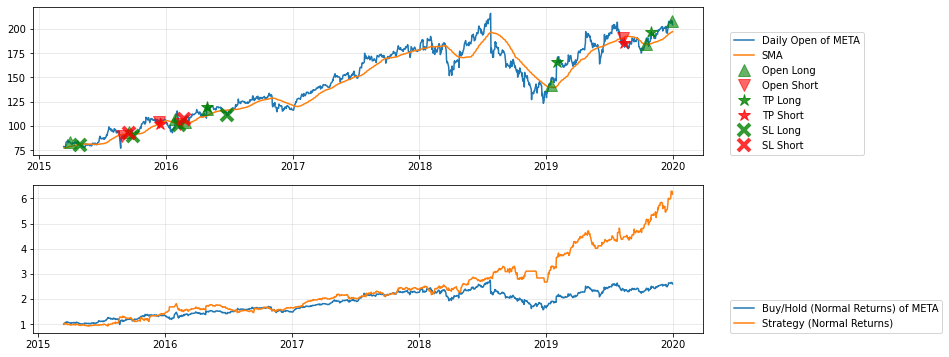

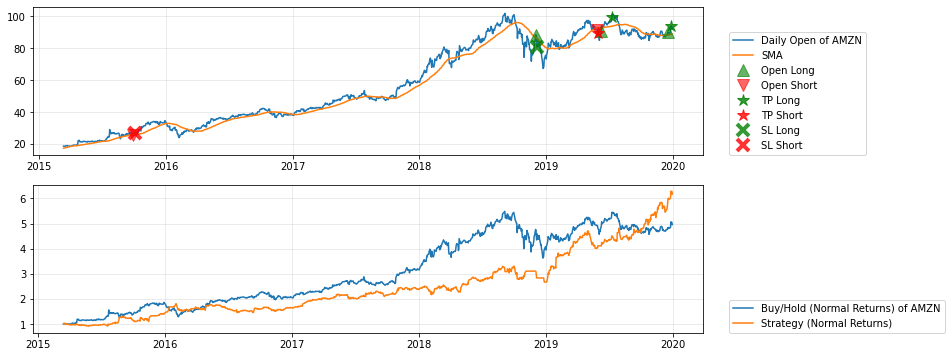

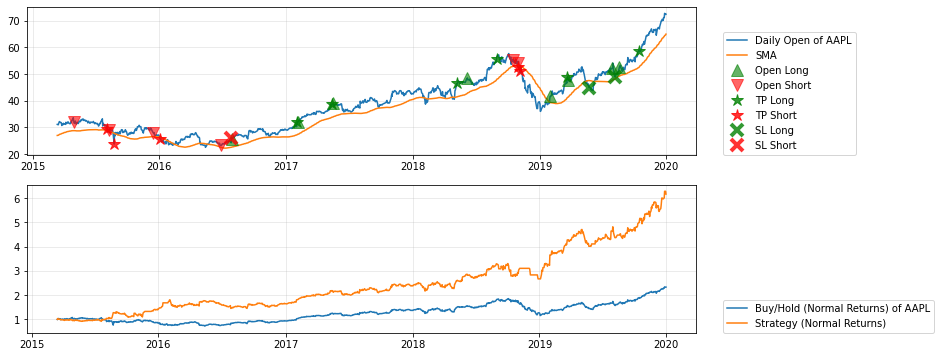

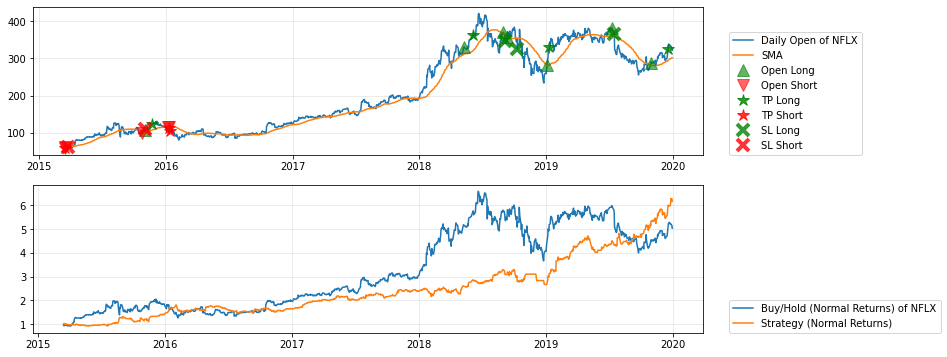

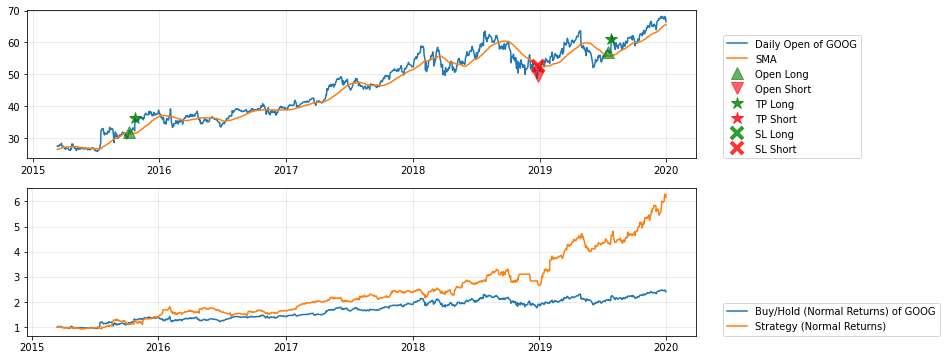

In [109]:
bt_data, returns_df,metrics_df = riding_the_trend_with_macd(MAANG_list, start, end,
                                                   lookback = lookback, verbose = verbose,
                                                   buy_on = buy_on,metrics_calc_start_date = metrics_calc_start_date)
print(f"Calcuation of metrics is from {metrics_calc_start_date}")
print(returns_df)
metrics_df

In [95]:
signals_df,temp_data = get_signal_for_mutiple_stocks(MAANG_list,start, end,primary_trend_window ,buy_on)

Use any of these below to copy the data back into excel

In [110]:
# temp_data.to_clipboard()

In [111]:
# bt_data[(bt_data["Invested Stock Returns"]!= 0.0) |(bt_data["Position"]!= 0.0)][["Chosen","Open_Entry","Close_Entry","Position","Invested Stock Price","Invested Stock Returns","Invested in","Strategy_Returns"]].to_clipboard()

In [112]:
# bt_data[(bt_data["Invested Stock Returns"]!= 0.0) |(bt_data["Position"]!= 0.0)].to_clipboard()

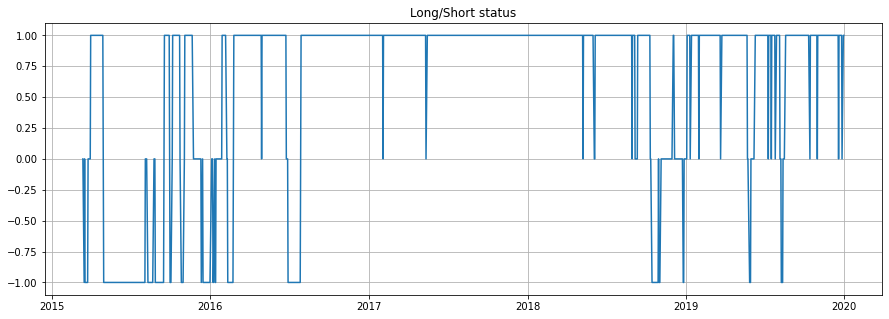

In [96]:
# Lets look from the position view Long or Short
plt.figure(figsize=(15, 5))
plt.plot(bt_data["Position"])
plt.title("Long/Short status")
plt.grid()
plt.show()

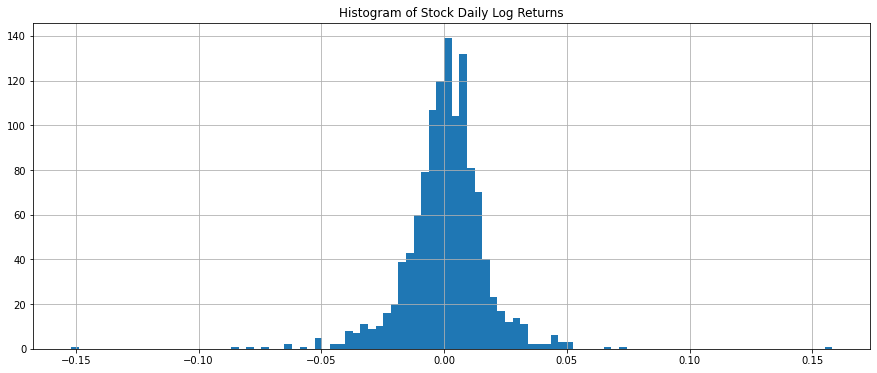

In [97]:
# The histogram of returns
plt.figure(figsize=(15, 6))
plt.hist(bt_data["Stock_Returns_AAPL"], bins = 100) 
plt.title("Histogram of Stock Daily Log Returns")
plt.grid()
plt.show()

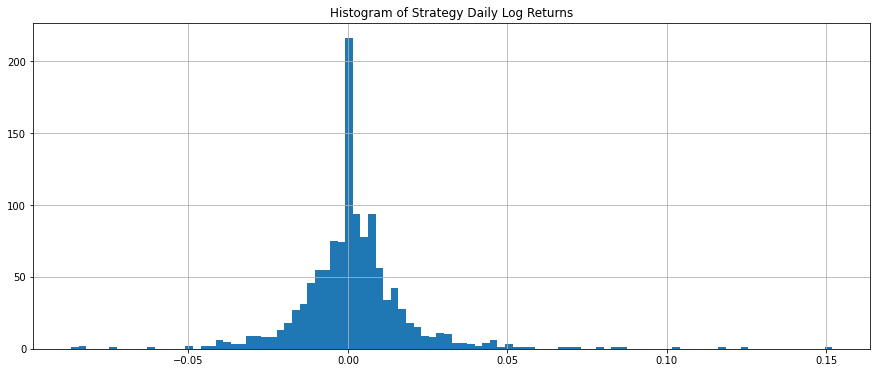

In [98]:
# The histogram of returns
plt.figure(figsize=(15, 6))
plt.hist(bt_data["Strategy_Returns"], bins = 100) 
plt.title("Histogram of Strategy Daily Log Returns")
plt.grid()
plt.show()

Max Drawdown for Strategy_Returns is 0.6943898693113821
Max days for drawdown for Strategy_Returns is 365 days 00:00:00


Max Drawdown for Stock_Returns_AAPL is 0.697749212114767
Max days for drawdown for Stock_Returns_AAPL is 659 days 00:00:00
Max Drawdown for Stock_Returns_META is 1.1783715590920398
Max days for drawdown for Stock_Returns_META is 119 days 00:00:00
Max Drawdown for Stock_Returns_AMZN is 1.8629144524987398
Max days for drawdown for Stock_Returns_AMZN is 137 days 00:00:00
Max Drawdown for Stock_Returns_GOOG is 0.5382397152497445
Max days for drawdown for Stock_Returns_GOOG is 276 days 00:00:00
Max Drawdown for Stock_Returns_NFLX is 2.9333185458208546
Max days for drawdown for Stock_Returns_NFLX is 396 days 00:00:00


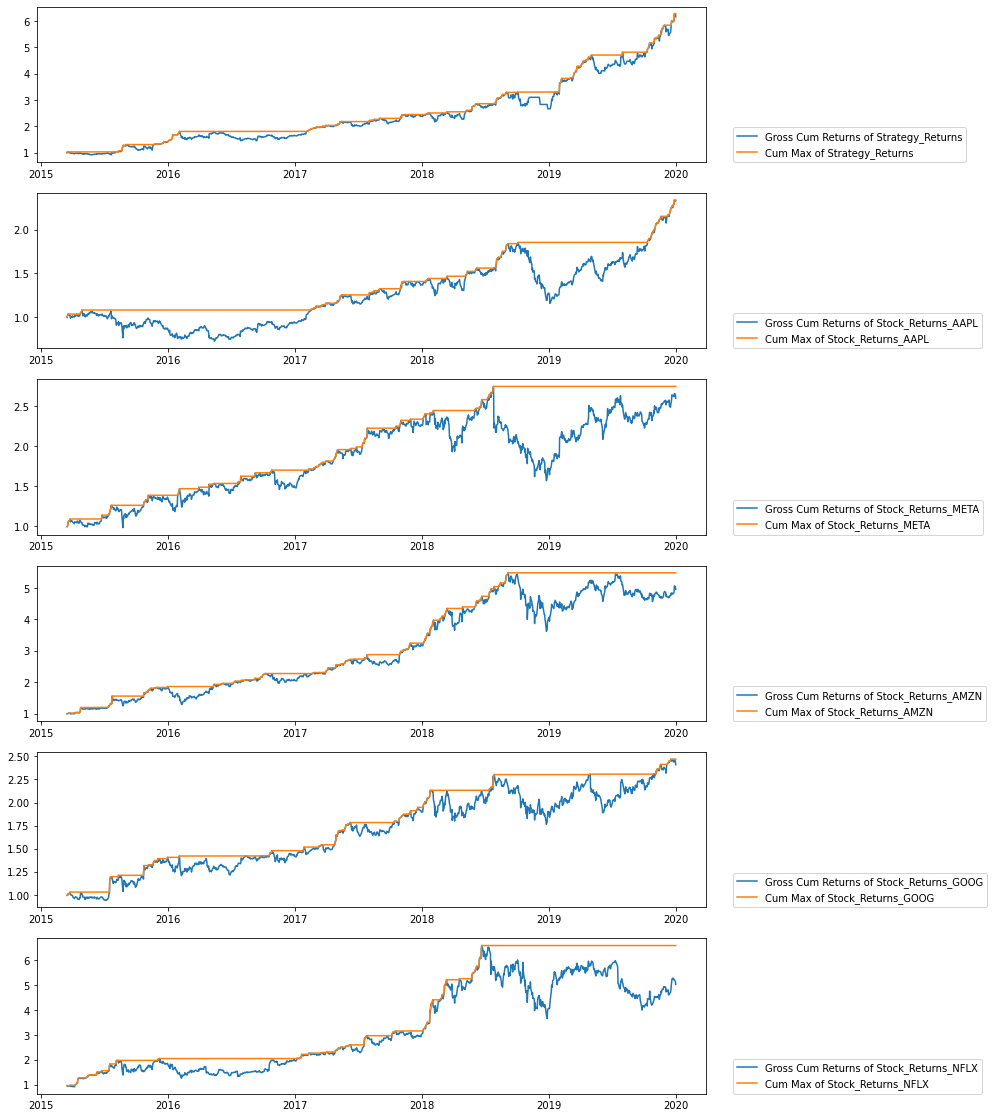

In [99]:
figure, axis = plt.subplots(6, figsize=(12, 20))
drawdown(bt_data, axis[0], "Strategy_Returns" )
print('\n')
drawdown(bt_data, axis[1], "Stock_Returns_AAPL")
drawdown(bt_data, axis[2], "Stock_Returns_META")
drawdown(bt_data, axis[3], "Stock_Returns_AMZN")
drawdown(bt_data, axis[4], "Stock_Returns_GOOG")
drawdown(bt_data, axis[5], "Stock_Returns_NFLX")

# Single Stock Demo

Distribution of postions,
  0.0    700
 1.0    474
-1.0     36
Name: Position, dtype: int64
                     1173
Close Long at TP       15
Close Long at SL       11
Close Short at SL       6
Close Short at TP       5
Name: Close_Entry, dtype: int64

Number of Entries and Exits are 75 and No trade are 700 

                      Normal       Log
Stock_Returns_META  2.595420  0.953748
Strategy_Returns    2.061447  0.723408


,Annual Mean Returns,Annual Regular std,Annual Sharpe Ratio
Stock_Returns_META,0.219933,0.307841,0.714438
Strategy_Returns,0.162746,0.177178,0.918547


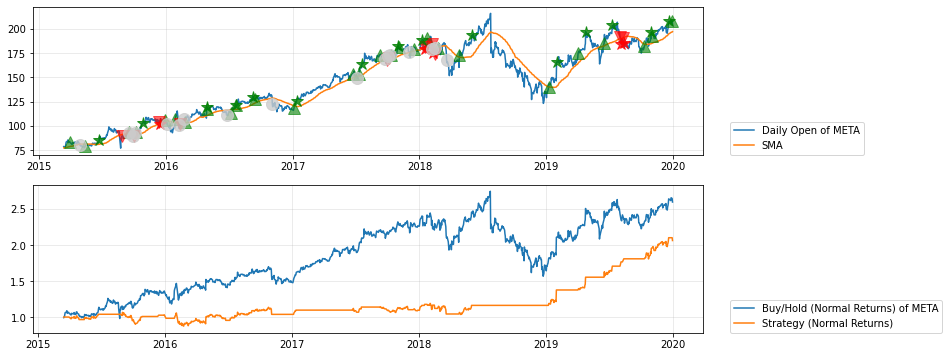

In [117]:
bt_data_single, returns_df_single,metrics_df_single = riding_the_trend_with_macd(["META"], start, end,
                                                   lookback = lookback, verbose = verbose,
                                                   buy_on = buy_on)
print(returns_df_single)
metrics_df_single
# Much Better SHARPE Ratio

# CRYPTO Demo

Distribution of postions,
  1.0    837
 0.0    709
-1.0    138
Name: Position, dtype: int64
                     1591
Close Long at TP       32
Close Long at SL       29
Close Short at TP      20
Close Short at SL      12
Name: Close_Entry, dtype: int64

Number of Entries and Exits are 187 and No trade are 709 

                          Normal       Log
Stock_Returns_BTC-USD   1.717053  0.540610
Stock_Returns_ETH-USD   1.366693  0.312394
Stock_Returns_XRP-USD   0.371436 -0.990378
Stock_Returns_LTC-USD   0.228725 -1.475236
Strategy_Returns       33.528696  3.512402


,Annual Mean Returns,Annual Regular std,Annual Sharpe Ratio
Stock_Returns_BTC-USD,0.084313,0.600552,0.140393
Stock_Returns_ETH-USD,0.047887,0.787614,0.060800
Stock_Returns_XRP-USD,-0.137821,0.934433,-0.147491
Stock_Returns_LTC-USD,-0.198196,0.820613,-0.241522
Strategy_Returns,0.692017,0.557688,1.240867


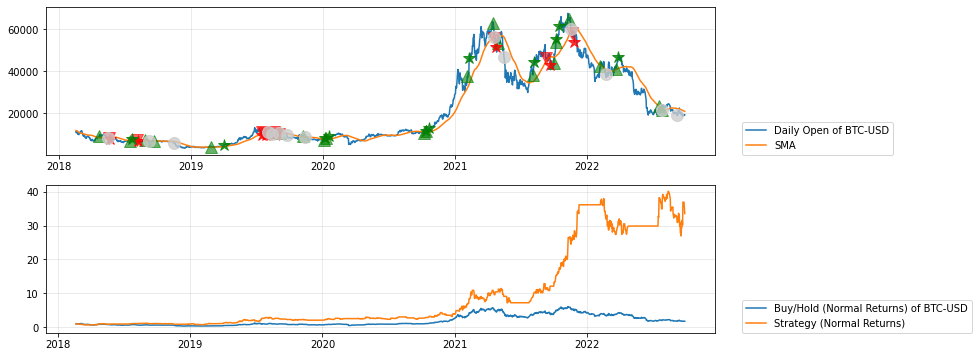

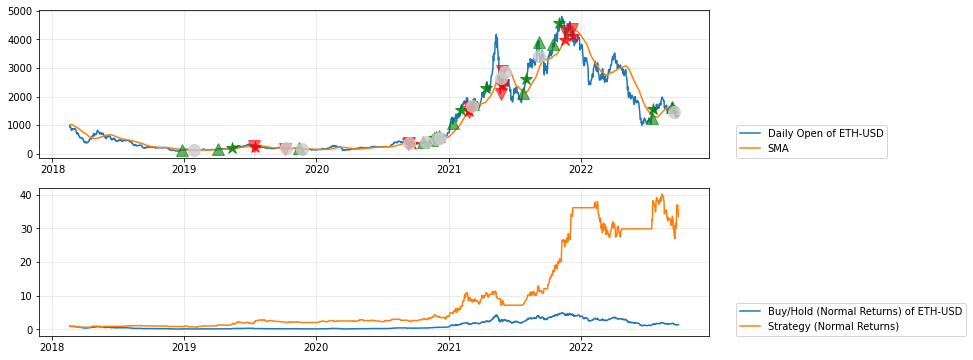

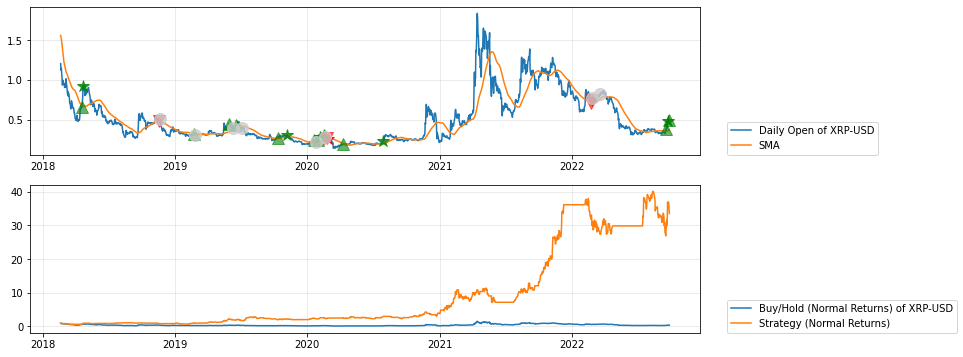

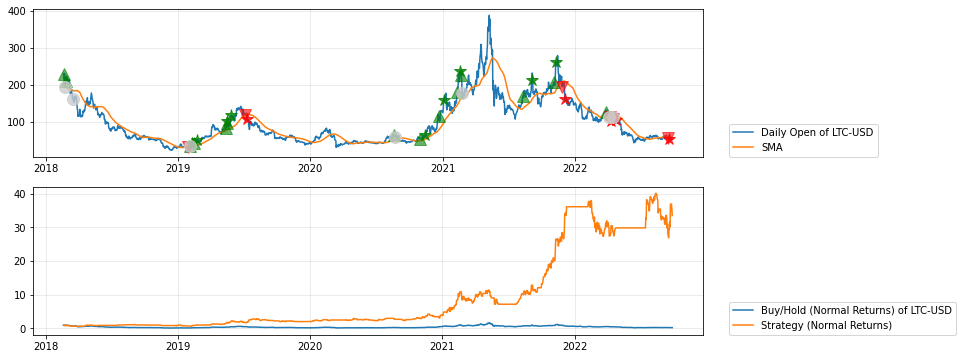

In [121]:
start = "2018-01-01"
end = "2022-12-31"

# Long Parameters
long_sl_ATR_multiple = 1.5 # Used for long SL
risk_reward_long = 2    # Used for long TP
close_n_sma_distance_long_multiple = 3 # Used to determine how close to SMA can be bought

# Short Params
short_sl_ATR_multiple= 1 # Used for Short SL
risk_reward_short= 0.7   # Used for Short TP
close_n_sma_distance_short_multiple = 0.5  # Used to determine how close to SMA can be bought

CRYPTO_list = ["BTC-USD","ETH-USD","XRP-USD","LTC-USD"]

bt_data_CRYPTO, returns_df_CRYPTO,metrics_df_CRYPTO = riding_the_trend_with_macd(CRYPTO_list, start, end,
                                                   lookback = lookback, verbose = verbose,
                                                   buy_on = buy_on)
print(returns_df_CRYPTO)
metrics_df_CRYPTO